# Develops the Calculation Model for the Online Calculator

In [107]:
import sys
from math import nan, isnan, inf
import numbers
from importlib import reload
import inspect
from pprint import pprint

import pandas as pd
import numpy as np
# import matplotlib pyplot commands
from matplotlib.pyplot import *
from IPython.display import Image, Markdown
from qgrid import show_grid as sh
 
# Show Plots in the Notebook
%matplotlib inline
 
# 'style' the plot like fivethirtyeight.com website
style.use('bmh')

In [108]:
rcParams['figure.figsize']= (10, 6)   # set Chart Size
rcParams['font.size'] = 14            # set Font size in Chart

In [109]:
# Access the directory where some utility modules are located in the
# actual heat pump calculator.
#sys.path.insert(0, '../../heat-pump-calc/heatpump/')
sys.path.insert(0, '../../heat-pump-calc/')

In [110]:
import heatpump.library as lib
reload(lib)

<module 'heatpump.library' from '../../heat-pump-calc/heatpump/library.py'>

In [111]:
import heatpump.hp_model
reload(heatpump.hp_model)
import heatpump.home_heat_model
reload(heatpump.home_heat_model)

<module 'heatpump.home_heat_model' from '../../heat-pump-calc/heatpump/home_heat_model.py'>

In [112]:
sh(lib.df_city[['Name', 'ElecUtilities']])

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [113]:
lib.fuels()

[('Natural Gas', 2),
 ('Propane', 3),
 ('#1 Oil', 4),
 ('#2 Oil', 5),
 ('Birch Wood', 6),
 ('Spruce Wood', 7),
 ('Wood Pellets', 8),
 ('Coal', 9),
 ('District Heat, Steam', 10),
 ('District Heat, Hot Water', 11)]

In [114]:
lib.city_from_id(45)

Name                                                            Ambler
Latitude                                                        67.087
Longitude                                                     -157.859
ERHRegionID                                                          5
WAPRegionID                                                          5
ImpCost                                                              5
FuelRefer                                                        False
FuelCityID                                                         NaN
Oil1Price                                                          NaN
Oil2Price                                                          NaN
PropanePrice                                                       NaN
BirchPrice                                                         NaN
SprucePrice                                                        NaN
CoalPrice                                                          NaN
SteamP

In [115]:
lib.heat_pump_from_id(601)

brand                Fujitsu
ahri_num             7993242
zones                 Single
outdoor_model      AOU12RLS3
indoor_model       ASU12RLS3
hspf                      14
in_pwr_5F_max            2.1
capacity_5F_max        16500
in_pwr_47F_min           0.2
cop_5F_max               2.3
cop_17F_max             2.49
cop_47F_max             3.34
Name: 601, dtype: object

In [10]:
util_id = 1
utility = lib.util_from_id(util_id)
utility

ID                                                              1
Name                                Chugach Electric- Residential
Active                                                       True
Type                                                            1
IsCommercial                                                False
ChargesRCC                                                   True
PCE                                                             0
CO2                                                           1.1
CustomerChg                                                     8
DemandCharge                                                  NaN
NameShort                                                  Chugac
Blocks          [(nan, 0.18715799739584343), (nan, nan), (nan,...
Name: 1, dtype: object

In [32]:
utility = lib.util_from_id(1)
inputs1 = dict(
    city_id=1,
    utility=utility,
    pce_limit=500,
    co2_lbs_per_kwh=1.1,
    exist_heat_fuel_id=2,
    exist_unit_fuel_cost=0.97852,
    exist_fuel_use=1600,
    exist_heat_effic=.8,
    exist_kwh_per_mmbtu=8,
    includes_dhw=True,
    occupant_count=3,
    includes_dryer=True,
    includes_cooking=False,
    elec_use_jan=550,
    elec_use_may=400,
    hp_model_id=575,
    low_temp_cutoff=5,
    garage_stall_count=2,
    garage_heated_by_hp=False,
    bldg_floor_area=3600,
    indoor_heat_setpoint=70,
    insul_level=3,  
    pct_exposed_to_hp=0.46,
    doors_open_to_adjacent=False,
    bedroom_temp_tolerance='med',
    capital_cost=4500,
    rebate_dol=500,
    pct_financed=0.5,
    loan_term=10,
    loan_interest=0.05,
    hp_life=14,
    op_cost_chg=10,
    sales_tax=0.02,
    discount_rate=0.05,
    inflation_rate=0.02,
    fuel_esc_rate=0.03,
    elec_esc_rate=0.02,
)

In [116]:
utility = lib.util_from_id(202)
inputs2 = dict(
    city_id=45,
    utility=utility,
    pce_limit=500,
    co2_lbs_per_kwh=1.6,
    exist_heat_fuel_id=4,
    exist_unit_fuel_cost=8.0,
    exist_fuel_use=450,
    exist_heat_effic=.86,
    exist_kwh_per_mmbtu=8,
    includes_dhw=False,
    occupant_count=3,
    includes_dryer=False,
    includes_cooking=False,
    elec_use_jan=550,
    elec_use_may=400,
    hp_model_id=601,
    low_temp_cutoff=5,
    garage_stall_count=0,
    garage_heated_by_hp=False,
    bldg_floor_area=800,
    indoor_heat_setpoint=70,
    insul_level=2,  
    pct_exposed_to_hp=1.0,
    doors_open_to_adjacent=False,
    bedroom_temp_tolerance='med',
    capital_cost=6500,
    rebate_dol=0,
    pct_financed=0.0,
    loan_term=10,
    loan_interest=0.05,
    hp_life=14,
    op_cost_chg=0,
    sales_tax=0.00,
    discount_rate=0.05,
    inflation_rate=0.02,
    fuel_esc_rate=0.03,
    elec_esc_rate=0.02,
)

In [117]:
mc = heatpump.hp_model.HP_model(**inputs2)
mc.run()
pprint(mc.summary)
mc.df_mo_dol_base

{'co2_driving_miles_saved': 796.3266503938855,
 'co2_lbs_saved': 710.2190533601442,
 'cop': 2.7431543036323394,
 'design_heat_load': 21201.927119512457,
 'design_heat_temp': -49.900000000000006,
 'elec_rate_avg_base': 0.24627016629582094,
 'elec_rate_avg_hp': 0.3136758601218221,
 'elec_rate_incremental': 0.43511107414166067,
 'elec_use_base': 5261.587156420448,
 'elec_use_chg': 2920.5773281426973,
 'elec_use_hp': 8182.164484563145,
 'fuel_desc': '#1 Oil',
 'fuel_price_incremental': 8.0,
 'fuel_unit': 'gallon',
 'fuel_use_base': 449.9792953956806,
 'fuel_use_chg': -242.80099829059915,
 'fuel_use_hp': 207.17829710508144,
 'hp_load_frac': 0.5462654060632223,
 'hp_max_capacity_5F': 13309.359,
 'irr': 0.0956901902635583,
 'max_hp_reached': False,
 'npv': 2294.3370660485407}


,elec_kwh,elec_kw,elec_dol,secondary_fuel_units,secondary_fuel_dol,total_dol
Jan,550.000000,1.883562,146.655009,76.734337,613.874695,760.529704
Feb,484.208794,1.658249,116.755398,55.524721,444.197766,560.953165
Mar,469.285322,1.607142,113.311061,47.586921,380.695371,494.006432
Apr,430.885219,1.475634,104.448316,40.356463,322.851707,427.300023
May,400.000000,1.369863,97.320007,22.190669,177.525356,274.845363
Jun,352.407154,1.206874,86.335577,8.411860,67.294878,153.630456
Jul,358.463021,1.227613,87.733272,9.867635,78.941079,166.674351
Aug,370.683244,1.269463,90.553699,14.447344,115.578754,206.132454
Sep,396.040992,1.356305,96.406268,25.830591,206.644725,303.050993
Oct,437.025287,1.496662,105.865444,33.141039,265.128308,370.993752


In [26]:
mc.df_mo_dol_hp

,elec_kwh,elec_kw,elec_dol,secondary_fuel_units,secondary_fuel_dol,total_dol
Jan,653.615890,3.255041,201.063714,69.320416,554.563328,755.627042
Feb,702.740128,3.038353,226.584839,40.433089,323.464710,550.049549
Mar,880.669272,3.132202,302.222518,19.384577,155.076615,457.299132
Apr,783.276874,3.010316,260.821010,14.361562,114.892498,375.713508
May,644.642737,2.802756,196.351911,1.679493,13.435944,209.787856
Jun,441.344680,1.787323,106.862360,0.000000,0.000000,106.862360
Jul,462.115940,1.818966,111.656367,0.000000,0.000000,111.656367
Aug,532.018275,2.261499,137.212805,0.000000,0.000000,137.212805
Sep,712.825388,2.440303,230.872083,0.000000,0.000000,230.872083
Oct,883.695310,2.984206,303.508887,0.000000,0.000000,303.508887


In [27]:
mc.df_cash_flow

,initial_cost,loan_cost,op_cost,fuel_cost,elec_cost,cash_flow,cum_disc_cash_flow
year,,,,,,,
0,-6500.0,0.0,0.0,0.000000,-0.000000,-6500.000000,-6500.000000
1,0.0,-0.0,0.0,1733.884116,-1236.389271,497.494845,-6026.195386
2,0.0,-0.0,0.0,1785.900639,-1261.117056,524.783583,-5550.201206
3,0.0,-0.0,0.0,1839.477659,-1286.339398,553.138261,-5072.379579
4,0.0,-0.0,0.0,1894.661988,-1312.066185,582.595803,-4593.076570
5,0.0,-0.0,0.0,1951.501848,-1338.307509,613.194339,-4112.622760
6,0.0,-0.0,0.0,2010.046903,-1365.073659,644.973244,-3631.333795
7,0.0,-0.0,0.0,2070.348311,-1392.375133,677.973178,-3149.510915
8,0.0,-0.0,0.0,2132.458760,-1420.222635,712.236125,-2667.441471


In [28]:
mc.df_mo_en_base

,hp_load_mmbtu,secondary_load_mmbtu,hp_kwh,secondary_fuel_mmbtu,secondary_kwh,hp_kw,secondary_fuel_units,cop,total_kwh,co2_lbs
Jan,0.0,9.070668,0.0,10.547288,72.565342,0.0,76.734337,NaN,72.565342,1817.382112
Feb,0.0,6.563506,0.0,7.631984,52.508049,0.0,55.524721,NaN,52.508049,1315.051886
Mar,0.0,5.625189,0.0,6.540918,45.001513,0.0,47.586921,NaN,45.001513,1127.052416
Apr,0.0,4.770486,0.0,5.547077,38.163887,0.0,40.356463,NaN,38.163887,955.805674
May,0.0,2.623131,0.0,3.050152,20.985045,0.0,22.190669,NaN,20.985045,525.565574
Jun,0.0,0.994355,0.0,1.156227,7.954841,0.0,8.411860,NaN,7.954841,199.227154
Jul,0.0,1.166440,0.0,1.356326,9.331524,0.0,9.867635,NaN,9.331524,233.705846
Aug,0.0,1.707802,0.0,1.985816,13.662417,0.0,14.447344,NaN,13.662417,342.172047
Sep,0.0,3.053401,0.0,3.550466,24.427208,0.0,25.830591,NaN,24.427208,611.773756
Oct,0.0,3.917560,0.0,4.555302,31.340478,0.0,33.141039,NaN,31.340478,784.914981


In [29]:
mc.df_mo_en_hp

,hp_load_mmbtu,secondary_load_mmbtu,hp_kwh,secondary_fuel_mmbtu,secondary_kwh,hp_kw,secondary_fuel_units,cop,total_kwh,co2_lbs
Jan,0.900312,8.194278,110.627011,9.528230,65.554221,1.371479,69.320416,2.385189,176.181232,1818.793441
Feb,1.832658,4.779544,232.803034,5.557609,38.236349,1.380103,40.433089,2.307192,271.039384,1330.105332
Mar,3.424761,2.291426,438.054054,2.664449,18.331408,1.525061,19.384577,2.291361,456.385462,1159.992340
Apr,3.156700,1.697662,376.974247,1.974025,13.581295,1.534681,14.361562,2.454215,390.555542,943.299173
May,2.490782,0.198531,264.039537,0.230850,1.588246,1.432893,1.679493,2.764762,265.627782,462.240505
Jun,1.021497,0.000000,96.892368,0.000000,0.000000,0.580449,0.000000,3.089858,96.892368,155.027789
Jul,1.198280,0.000000,112.984442,0.000000,0.000000,0.591353,0.000000,3.108354,112.984442,180.775107
Aug,1.754418,0.000000,174.997447,0.000000,0.000000,0.992036,0.000000,2.938275,174.997447,279.995916
Sep,3.136747,0.000000,341.211605,0.000000,0.000000,1.083998,0.000000,2.694304,341.211605,545.938567
Oct,4.024493,0.000000,478.010501,0.000000,0.000000,1.487544,0.000000,2.467543,478.010501,764.816802


In [30]:
mc.city

Name                                                            Ambler
Latitude                                                        67.087
Longitude                                                     -157.859
ERHRegionID                                                          5
WAPRegionID                                                          5
ImpCost                                                              5
FuelRefer                                                        False
FuelCityID                                                         NaN
Oil1Price                                                          NaN
Oil2Price                                                          NaN
PropanePrice                                                       NaN
BirchPrice                                                         NaN
SprucePrice                                                        NaN
CoalPrice                                                          NaN
SteamP

In [96]:
# Model an average Enstar Home, probably somewhere between an
# insulation level 1 and 2.  Space Heating for Average Enstar
# House is about 1326 CCF, from "accessible_UA.ipynb"
m = heatpump.hp_model.HP_model(**inputs1)
m.insul_level = 2
m.exist_heat_effic = 0.76
m.bldg_floor_area = 2100
m.garage_stall_count = 1
m.exist_fuel_use = None
m.run()
f_level2 = m.summary['fuel_use_base']

m.insul_level = 1
m.run()
f_level1 = m.summary['fuel_use_base']

# Assuming 2/3 Level 2 and 1/3 Level 1
print(0.67 * f_level2 + 0.33 * f_level1)

1488.2402749086582


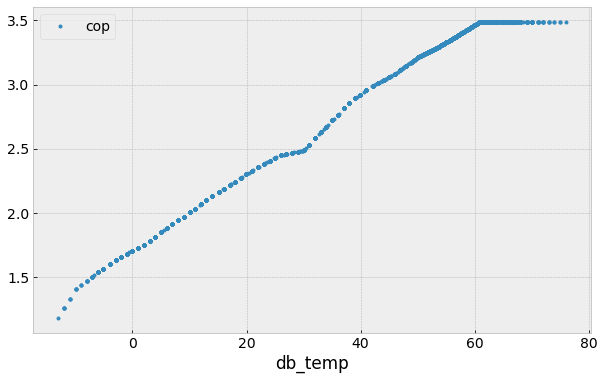

In [97]:
# Check whether COP is getting modeled correctly
m.df_hourly.plot(x='db_temp', y='cop', marker='.', linewidth=0)

In [101]:
off_days = set(m.df_hourly.query('running == False')['day_of_year'])
off_days, len(off_days)

({2,
  3,
  4,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  32,
  33,
  34,
  35,
  36,
  37,
  323,
  324,
  325,
  340,
  347,
  348,
  349},
 23)

In [102]:
dft = m.df_hourly[['db_temp', 'day_of_year']].copy()
dft.head()

,db_temp,day_of_year
timestamp,,
2018-01-01 00:30:00,21.02,1
2018-01-01 01:30:00,19.94,1
2018-01-01 02:30:00,21.02,1
2018-01-01 03:30:00,19.04,1
2018-01-01 04:30:00,19.04,1


In [105]:
sh(m.df_hourly[['db_temp', 'running']])

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [106]:
m

city_id: 1

utility:
ID                                                              1
Name                                Chugach Electric- Residential
Active                                                       True
Type                                                            1
IsCommercial                                                False
ChargesRCC                                                   True
PCE                                                             0
CO2                                                           1.1
CustomerChg                                                     8
DemandCharge                                                  NaN
NameShort                                                  Chugac
Blocks          [(nan, 0.18715799739584343), (nan, nan), (nan,...
Name: 1, dtype: object

pce_limit: 500
co2_lbs_per_kwh: 1.1
exist_heat_fuel_id: 2
exist_unit_fuel_cost: 0.97852
exist_fuel_use: None
exist_heat_effic: 0.76
exist_kwh_per_mmbtu: 8
includes